# Data Preprocessing and SVD Analysis
This notebook performs text preprocessing, TF-IDF vectorization, and dimensionality reduction using SVD/PCA on earnings call transcripts. The goal is to analyze sector-based clustering of companies.

# 1. Imports

In [ ]:
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
import re

# 2. Data Settings

---

### 2.1. Custom Stopword Compilation
This notebook defines a comprehensive set of custom stopwords to improve the quality of text analysis on earnings call transcripts. The table below summarizes each category:

| **Category**                  | **Description**                                                                 |
|------------------------------|---------------------------------------------------------------------------------|
| Company-specific         | Names and aliases of companies (e.g., "meta", "jp morgan", "nvidia")           |
| Domain-specific          | Roles and filler words common in financial speech (e.g., "ceo", "analyst")     |
| Name stopwords           | First/last names of speakers to reduce individual bias                         |
| Month/time stopwords     | Temporal terms like months and quarters ("jan", "Q1")                          |
| Transcript stopwords     | Common transcript metadata (e.g., "goldman", "quarterly", "transcript")        |
| Mid-sentence fillers     | Verbal tics and soft phrases (e.g., "uh", "yeah", "actually")                  |
| Negation/bad words       | Partial negations and contractions that add noise (e.g., "don", "isn")         |
| Platform-specific        | Product and platform terms (e.g., "azure", "youtube", "facebook")             |
| Additional English       | Reserved for any manually added stopwords beyond scikit-learn defaults         |

All sets are unified into a single `custom_stopwords` list using Python `set.union()` for streamlined filtering during preprocessing.

In [2]:
# -----------------------------
# Company-specific Stopwords
# -----------------------------
company_stopwords = {
    # 3M
    "3m",
    # AMD
    "advanced micro devices", "amd", "amd inc",
    # American Airlines
    "aal", "american airlines", "american airlines inc", "americanairlines",
    # ASML
    "asml", "asml holding", "asml holding nv",
    # Blackstone
    "blackstone", "blackstone group", "blackstone inc",
    # CBRE
    "cbre", "cbre group", "cbre inc",
    # Citigroup
    "citi", "citigroup", "citigroup inc",
    # Cushman & Wakefield
    "cushman", "cushman & wakefield", "cushman & wakefield plc", "cushman wakefield", "cushmanwakefield", "wakefield",
    # Delta Airlines
    "dal", "delta", "delta air lines", "delta air lines inc", "delta airlines",
    # Google
    "alphabet", "alphabet inc", "google", "google llc",
    # Intel
    "intel", "intel corp", "intel corp inc", "intel corporation",
    # JPMorgan Chase
    "chase", "jp morgan", "jpmc", "jpmorgan", "jpmorgan chase", "jpmorgan chase & co", "jpmorgan chase & co inc",
    # Meta
    "facebook", "facebook inc", "meta", "meta platforms", "meta platforms inc",
    # Microsoft
    "microsoft", "microsoft corp", "microsoft corp inc", "microsoft corporation", "msft",
    # Netflix
    "netflix", "netflix inc",
    # Nvidia
    "geforce", "nvidia", "nvidia corp", "nvidia corp inc", "nvidia corporation", "nvda", "rtx", "gtx", "cuda",
    # Southwest Airlines
    "southwest", "southwest airlines", "southwest airlines co",
    # TSMC
    "taiwan semiconductor", "taiwan semiconductor manufacturing", "taiwan semiconductor manufacturing company limited", "tsmc",
    # Uber
    "uber", "uber technologies", "uber technologies inc",
    # United Airlines
    "ual", "united", "united airlines", "united airlines holdings", "united airlines holdings inc",
}

# -----------------------------
# Domain-specific Stopwords
# -----------------------------
domain_stopwords = {
    # Roles
    "analyst", "board", "ceo", "chairman", "cfo", "coo", "cto", "director", "executive", "manager", "officer", "partner", "president", "vp",

    # Conversational/Filler
    "afternoon", "anybody", "anyone", "appreciate", "awesome", "comment", "comments", "consent logo", "cetera", "et cetera",
    "everyone", "guess", "guys", "hello", "hi", "inc", "just", "let", "llc", "nii", "okay", "operator", "question", "right",
    "sure", "talk", "talking", "team", "thank", "thanks", "today", "welcome", "yes", "etc", "factset", "factset copyright",
}

# -----------------------------
# Name-specific Stopwords
# -----------------------------
name_stopwords = {
    "amy", "andrew", "barnum", "bernstein", "bob", "brad", "bradley", "brian", "brett", "bruce", "carl", "chris", "dan", "daniel",
    "dara", "david", "devon", "duane", "emma", "fraser", "glen", "hauenstein", "huang", "isom", "james", "jamie", "jane", "jean",
    "jeff", "jensen", "jeremy", "joe", "john", "jon", "jordan", "khosrowshahi", "lisa", "mark", "mary", "mason", "michael", "michelle",
    "mike", "monish", "morgan", "patolawala", "peter", "phil", "philipp", "raymond", "robert", "roger", "ryan", "satya", "scott",
    "spencer", "stanley", "stephen", "steve", "su", "sundar", "tammy", "vasu", "wang", "wendell", "wennink", "wei", "william",
}

# -----------------------------
# Month/Time Stopwords
# -----------------------------
month_stopwords = {
    "april", "august", "december", "february", "january", "july", "june",
    "march", "may", "november", "october", "september",
    "apr", "aug", "dec", "feb", "jan", "jul", "jun", "mar", "may", "nov", "oct", "sep", "sept"
}

# -----------------------------
# Transcript Stopwords
# -----------------------------
transcript_stopwords = {
    "annual", "bank", "bank america", "bank of america", "barclays", "baird", "bmo", "boa", "bofa", "closing", "com",
    "copyright", "copyright global", "copyright group", "cowen", "db", "deutsche bank", "et", "fargo", "first quarter",
    "fourth quarter", "goldman", "goldman sachs", "jefferies", "ll", "marketintelligence", "month", "oq", "quarter", "quarterly",
    "republication", "reserved redistribution", "rights reserved", "second quarter", "td", "third quarter", "transcript", "ubs",
    "wells", "wells fargo", "written consent",
}

# -----------------------------
# Common Mid-sentence Fillers
# -----------------------------
common_mid_sentence_stopwords = {
    "absolutely", "actually", "ah", "essentially", "especially", "okay", "ok", "uh", "um", "yeah", "yep", "yup",
}

# -----------------------------
# Negation/Bad Words
# -----------------------------
bad_words = {
    "didn", "doesn", "don", "hadn", "hasn", "haven", "isn", "ma", "mightn", "mustn", "needn",
}

# -----------------------------
# Platform-specific Stopwords
# -----------------------------
platform_stopwords = {
    "adsense", "airline", "airlines", "android", "azure", "chrome", "copilot", "core i7", "epyc", "facebook", "gemini", "geforce",
    "instagram", "linkedin", "llama", "metaverse", "messenger", "pixel", "radeon", "reels", "search", "skyclub", "skymiles",
    "skyteams", "snapchat", "tiktok", "twitter", "x", "x86", "youtube", "morgan stanely", "euv",
}

# -----------------------------
# Additional English Stopwords
# -----------------------------
more_english_stopwords = {
    
}

# -----------------------------
# Combine All Custom Stopwords
# -----------------------------
custom_stopwords = ENGLISH_STOP_WORDS \
    .union(domain_stopwords) \
    .union(company_stopwords) \
    .union(name_stopwords) \
    .union(month_stopwords) \
    .union(transcript_stopwords) \
    .union(common_mid_sentence_stopwords) \
    .union(platform_stopwords) \
    .union(more_english_stopwords) \
    .union(bad_words)

---

### 2.2. Company to Sector Mapping

In [ ]:
# This dictionary maps each company to its respective industry sector to enable sector-based grouping, filtering, or coloring
# in visualizations.
company_to_sector = {
    "delta": "Airlines",
    "southwest": "Airlines",
    "united": "Airlines",
    "americanairlines": "Airlines",
    "cushmanwakefield": "RealEstate",
    "cbre": "RealEstate",
    "amd": "Semiconductors",
    "asml": "Semiconductors",
    "intel": "Semiconductors",
    "nvidia": "Semiconductors",
    "tsmc": "Semiconductors",
    "microsoft": "Tech",
    "google": "Tech",
    "meta": "Tech",
    "netflix": "Tech",
    "uber": "Tech",
    "blackstone": "Finance",
    "citigroup": "Finance",
    "jpmc": "Finance",
    "3m": "ConsumerGoods",
}


# 3. Text Cleaning Function

This function normalizes raw transcript text by:
- Lowercasing all characters
- Removing URLs and email addresses
- Stripping out financial boilerplate, common transcript fillers, and numbers

In [ ]:
def clean_text(text):
    # Convert all text to lowercase for normalization (case-insensitive processing)
    text = text.lower()
    
    # Remove URLs and email addresses (to eliminate noise from metadata)
    text = re.sub(r"http\S+|www\S+|\S+@\S+", "", text)
    
    # Define regex patterns to remove financial boilerplate, common transcript phrases, and numbers
    patterns = [
        r"\b(q[1-4]|fy\d{2}|eps|gaap|non[- ]?gaap|ebitda|na|nm)\b",  # Financial jargon and abbreviations
        r"\b(thank you|good morning|good afternoon|prior written consent|refinitiv|spglobal|callstreet)\b",  # Repeated formal or legal phrases
        r"\b\d+\b",  # Standalone numbers (e.g., dates, financial figures)
    ]
    
    # Apply all patterns to the text
    for p in patterns:
        text = re.sub(p, "", text, flags=re.IGNORECASE)

    # Return the cleaned and normalized string
    return text

# 4. Load Data

In [5]:
# 1. Load all .txt files and metadata
base_dir = "../data"
documents = []
companies = []
quarters = []

for company in os.listdir(base_dir):
    company_path = os.path.join(base_dir, company)
    if os.path.isdir(company_path):
        for file_path in glob.glob(f"{company_path}/*.txt"):
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
            cleaned = clean_text(text)
            documents.append(cleaned)
            companies.append(company)
            quarters.append(os.path.basename(file_path).split('-')[0] + "-" + os.path.basename(file_path).split('-')[1])  # e.g., "Q1-2023"

# 2. TF-IDF Vectorization with ngrams
vectorizer = TfidfVectorizer(
    stop_words=list(custom_stopwords),
    ngram_range=(1, 2),
    max_features=1000,
    min_df=2,
    max_df=0.9,
    token_pattern=r'(?u)\b[a-zA-Z]{2,}\b'
)

tfidf_matrix = vectorizer.fit_transform(documents)
tfidf_terms = vectorizer.get_feature_names_out()

c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['advanced', 'air', 'america', 'american', 'company', 'consent', 'core', 'corp', 'corporation', 'deutsche', 'devices', 'fourth', 'global', 'group', 'holding', 'holdings', 'jp', 'limited', 'lines', 'logo', 'manufacturing', 'micro', 'nv', 'platforms', 'plc', 'redistribution', 'reserved', 'rights', 'sachs', 'second', 'semiconductor', 'stanely', 'taiwan', 'technologies', 'written'] not in stop_words.
  warnings.warn(


# 5. SVD

The following visualizations illustrate the results of Singular Value Decomposition (SVD) applied to the TF-IDF matrix of earnings call transcripts of 20 differnet companies from different sectors.

| Left Plot | Right Plot |
|---------------|----------------|
| **2D SVD Projection**: This scatter plot shows the projection of documents onto the first two SVD components (conceptually similar to PCA). Each point represents a document, reduced to two dimensions that capture the most significant variation in term usage. Visual clustering patterns may suggest sector-based grouping. | **Cumulative Variance Explained**: This line plot shows the cumulative proportion of variance captured as more singular vectors are included. The curve demonstrates that a small number of components (e.g., ~20–30) capture the majority of the variance, indicating strong dimensionality reduction potential. |

**Key Observations:**
- The first two components show some separation between groups, indicating potential for downstream clustering or classification.
- Over 90% of the variance is explained by the first ~30 components, justifying dimensionality reduction before applying further unsupervised learning.


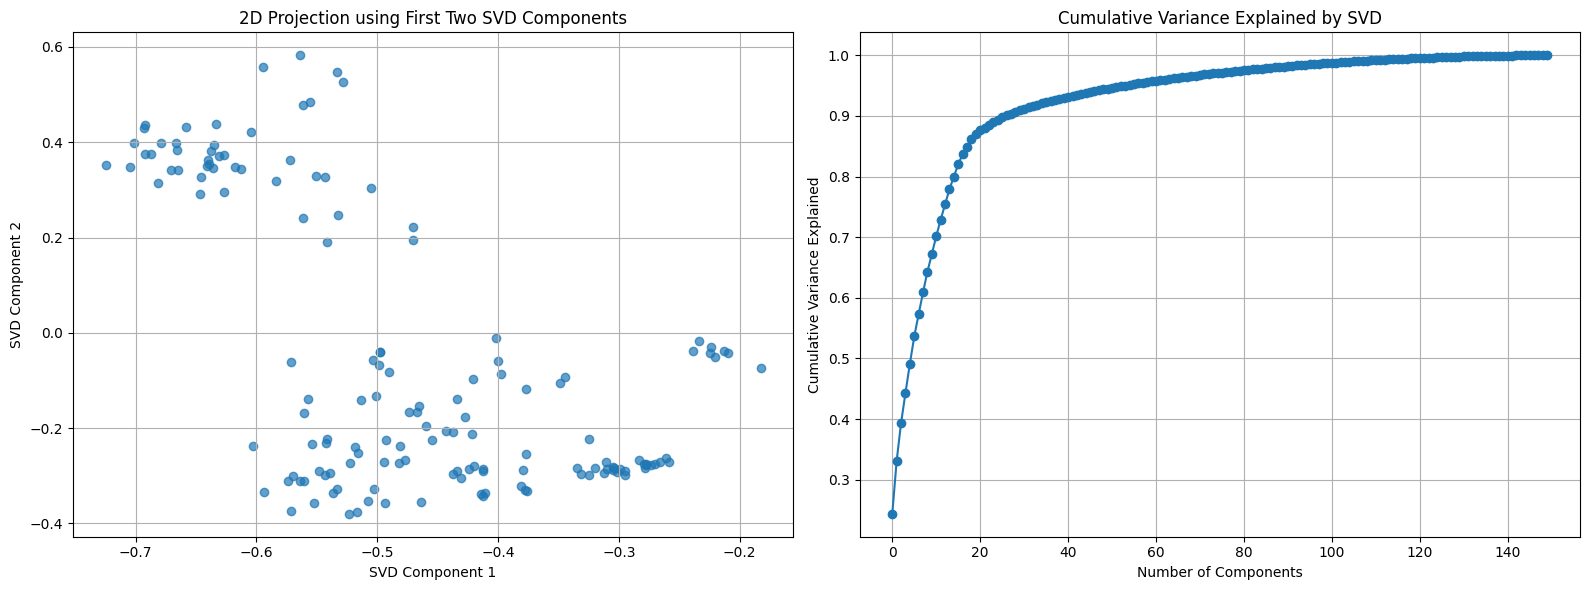

In [ ]:
# Convert sparse matrix to dense
np.random.seed(42)
tfidf_dense = tfidf_matrix.toarray()

# SVD
U, S, VT = np.linalg.svd(tfidf_dense, full_matrices=False)

explained_variance = (S ** 2) / np.sum(S ** 2) # Explained variance
svd_projection = U[:, :2] @ np.diag(S[:2]) # 2D SVD Projection

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D SVD Projection
axes[0].scatter(svd_projection[:, 0], svd_projection[:, 1], alpha=0.7)
axes[0].set_title('2D Projection using First Two SVD Components')
axes[0].set_xlabel('SVD Component 1')
axes[0].set_ylabel('SVD Component 2')
axes[0].grid(True)

# Plot 2: Cumulative Variance Explained
axes[1].plot(np.cumsum(explained_variance), marker='o')
axes[1].set_title('Cumulative Variance Explained by SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# 6. Truncated SVD
This section uses **Truncated Singular Value Decomposition (Truncated SVD)** to reduce the dimensionality of the sparse TF-IDF matrix. This approach is also known as Latent Semantic Analysis (LSA). It is ideal for handling large text corpora while preserving latent topic structures.

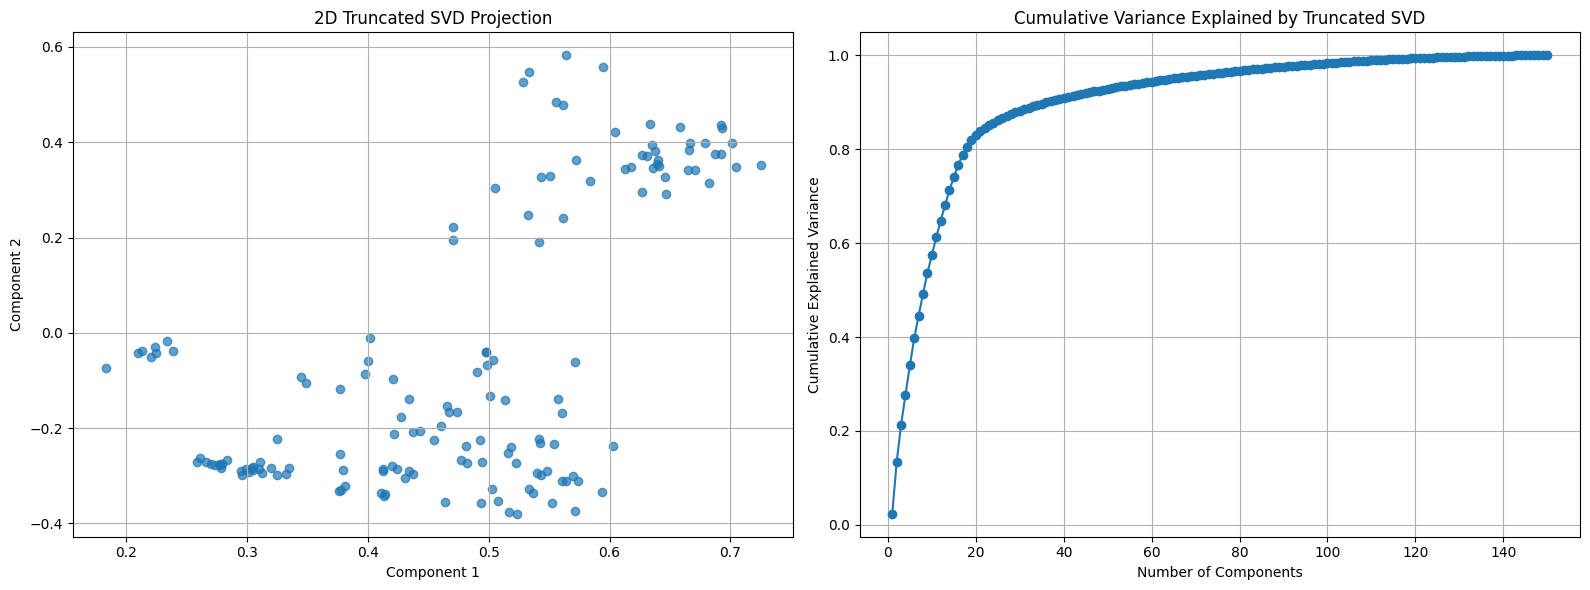

In [12]:
# Set number of components
n_components = 150
np.random.seed(42)

# Apply Truncated SVD on the sparse TF-IDF matrix
svd = TruncatedSVD(n_components=n_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Calculate explained variance
explained_variance = svd.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: 2D projection from first two SVD components
axes[0].scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], alpha=0.7)
axes[0].set_title('2D Truncated SVD Projection')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')
axes[0].grid(True)

# Plot 2: Cumulative explained variance
axes[1].plot(range(1, n_components + 1), cumulative_variance, marker='o')
axes[1].set_title('Cumulative Variance Explained by Truncated SVD')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].grid(True)

plt.tight_layout()
plt.show()


# PCA

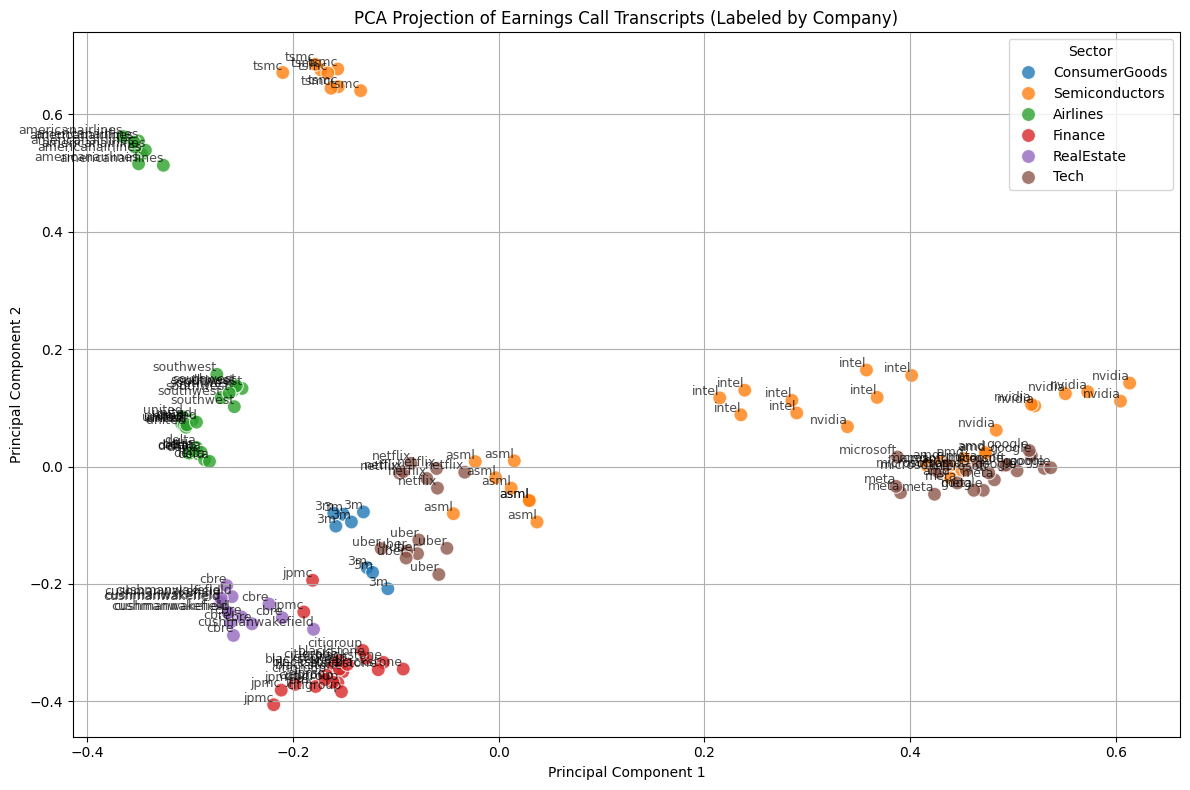

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Reduce to 2 principal components
np.random.seed(42)
pca = PCA(n_components=50)
pca_result = pca.fit_transform(reduced_matrix)

# Create DataFrame for plotting
df_pca = pd.DataFrame({
    "PC1": pca_result[:, 0],
    "PC2": pca_result[:, 1],
    "Company": [c.strip().lower() for c in companies],
    "Quarter": quarters
})
df_pca["Sector"] = df_pca["Company"].map(company_to_sector)

# Plot with Seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x="PC1", y="PC2", hue="Sector", palette="tab10", s=100, alpha=0.8)

# Add company name labels
for i in range(len(df_pca)):
    plt.text(
        df_pca["PC1"][i],
        df_pca["PC2"][i],
        df_pca["Company"][i],
        fontsize=9,
        ha='right',
        va='bottom',
        alpha=0.7
    )

plt.title("PCA Projection of Earnings Call Transcripts (Labeled by Company)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()


# T-SNE

c:\Users\sahn1\Documentos\2025 Spring Quarter\DATA-5322\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


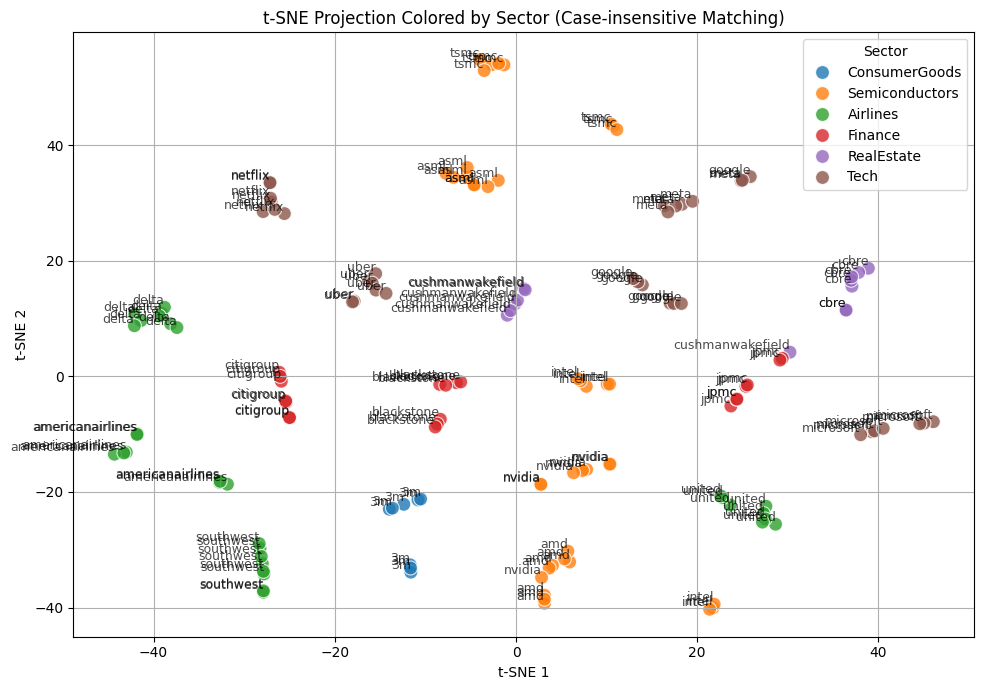

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

# Adjust n_components for SVD to be less than or equal to number of features
n_features = tfidf_matrix.shape[1]
n_svd_components = min(40, n_features - 1)  # subtracting 1 to be safe

# Step 2: SVD (standard dimensionality reduction before t-SNE)
svd = TruncatedSVD(n_components=n_svd_components, random_state=42)
reduced_matrix = svd.fit_transform(tfidf_matrix)

# Step 3: PCA to 10 dimensions before t-SNE
n_pca_components = min(10, reduced_matrix.shape[1])
pca = PCA(n_components=n_pca_components, random_state=42)
pca_result = pca.fit_transform(reduced_matrix)

# t-SNE usually works better on already reduced data (e.g., via SVD)
tsne = TSNE(n_components=2, perplexity=2, random_state=42, n_iter=500)
tsne_result = tsne.fit_transform(pca_result)

# Prepare dataframe for plotting
df_plot = pd.DataFrame({
    "x": tsne_result[:, 0],
    "y": tsne_result[:, 1],
    "Company": companies,
    "Quarter": quarters
})

df_plot["Company"] = df_plot["Company"].str.strip().str.lower()
df_plot["Sector"] = df_plot["Company"].map(company_to_sector)

# Plot again using seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="x", y="y", hue="Sector", palette="tab10", s=100, alpha=0.8)

for i in range(len(df_plot)):
    plt.text(
        df_plot["x"][i],
        df_plot["y"][i],
        df_plot["Company"][i],
        fontsize=9,
        ha='right',  # horizontal alignment
        va='bottom', # vertical alignment
        alpha=0.7
    )

plt.title("t-SNE Projection Colored by Sector (Case-insensitive Matching)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()